## SQL Generation Agent with DuckDB

In [1]:
import os

In [2]:
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = os.environ.get("LANGCHAIN_TRACING_V2")
os.environ["OPENAI_API_KEY"] = os.environ.get("OPENAI_API_KEY")


### DuckDB Loader Example

In [3]:
from langchain_community.document_loaders import DuckDBLoader

### Build the SQL Generation Agent

In [25]:
from typing_extensions import TypedDict

global store
store = InMemoryStore()
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str
    code: str

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [6]:
from langchain import hub
query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")
assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


### Define Write Query

In [7]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):

    file_path = "data/AB_NYC_2019.csv"
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": "duckdb",
            "top_k": 10,
            "table_info": f"read_csv_auto('{file_path}')",
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [8]:
def execute_query(state: State):
    """Execute SQL query."""
    data = DuckDBLoader(state["query"]).load()
    return {'result': data}

In [9]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [19]:
def write_code_for_chart(state: State):
    """Generate Python Code for Data Visualization """
    chart_type = store.mget(['chart_type'])[0]

    prompt = (
        "Given the following user question, corresponding SQL query, "
        f"and SQL result, build a python plotly script to with {chart_type} chart to show the data, return executable code only\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"code": response.content}

In [20]:
def execute_python_code(state: State):
    code = state["code"]
    code = code.replace("python", "")
    code = code.replace("```", "")
    exec(code)

In [21]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer, write_code_for_chart, execute_python_code]
)

graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

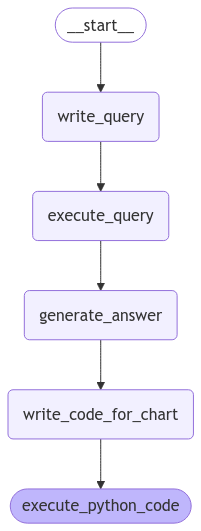

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
from langchain.storage import InMemoryStore

def llm_chart(question: str, chart_type: str):
    store = InMemoryStore()
    store.mset([('chart_type', chart_type)])
    for step in graph.stream({"question": question}, stream_mode="updates"):
        print(step)

{'write_query': {'query': "SELECT neighbourhood, AVG(price) as average_price \nFROM read_csv_auto('data/AB_NYC_2019.csv') \nGROUP BY neighbourhood \nORDER BY average_price DESC \nLIMIT 10;"}}
{'execute_query': {'result': [Document(metadata={}, page_content='neighbourhood: Fort Wadsworth\naverage_price: 800.0'), Document(metadata={}, page_content='neighbourhood: Woodrow\naverage_price: 700.0'), Document(metadata={}, page_content='neighbourhood: Tribeca\naverage_price: 490.638418079096'), Document(metadata={}, page_content='neighbourhood: Sea Gate\naverage_price: 487.85714285714283'), Document(metadata={}, page_content='neighbourhood: Riverdale\naverage_price: 442.09090909090907'), Document(metadata={}, page_content="neighbourhood: Prince's Bay\naverage_price: 409.5"), Document(metadata={}, page_content='neighbourhood: Battery Park City\naverage_price: 367.5571428571429'), Document(metadata={}, page_content='neighbourhood: Flatiron District\naverage_price: 341.925'), Document(metadata={}

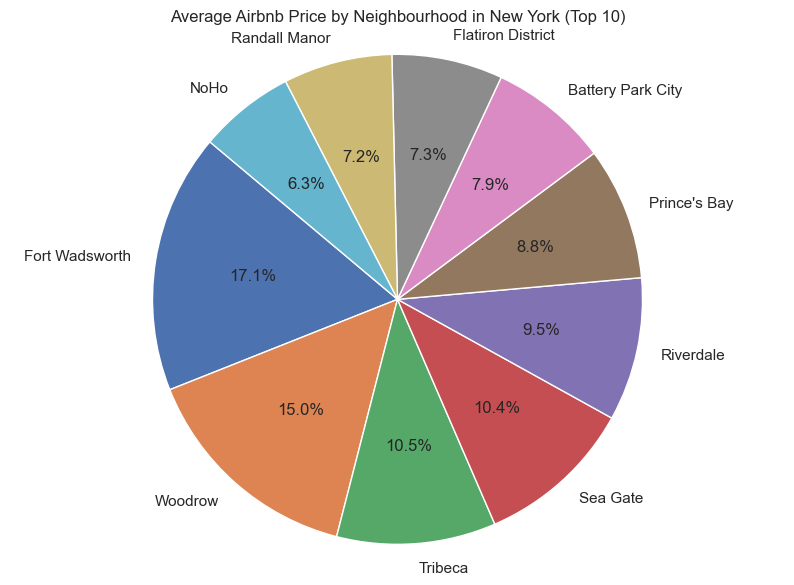

{'execute_python_code': None}


In [172]:
question = "This is a dataset about New York Airbnb, can you provide average price for each neighbourhood and rank them in descending order? "
chart_type = 'pie'
llm_chart(question, chart_type)

In [26]:
question = "This is a dataset about New York Airbnb, can you show all the host by latitude and longitude"
chart_type = 'map'
llm_chart(question, chart_type)

{'write_query': {'query': "SELECT host_id, host_name, latitude, longitude FROM read_csv_auto('data/AB_NYC_2019.csv') LIMIT 10"}}
{'execute_query': {'result': [Document(metadata={}, page_content='host_id: 2787\nhost_name: John\nlatitude: 40.64749\nlongitude: -73.97237'), Document(metadata={}, page_content='host_id: 2845\nhost_name: Jennifer\nlatitude: 40.75362\nlongitude: -73.98377'), Document(metadata={}, page_content='host_id: 4632\nhost_name: Elisabeth\nlatitude: 40.80902\nlongitude: -73.9419'), Document(metadata={}, page_content='host_id: 4869\nhost_name: LisaRoxanne\nlatitude: 40.68514\nlongitude: -73.95976'), Document(metadata={}, page_content='host_id: 7192\nhost_name: Laura\nlatitude: 40.79851\nlongitude: -73.94399'), Document(metadata={}, page_content='host_id: 7322\nhost_name: Chris\nlatitude: 40.74767\nlongitude: -73.975'), Document(metadata={}, page_content='host_id: 7356\nhost_name: Garon\nlatitude: 40.68688\nlongitude: -73.95596'), Document(metadata={}, page_content='host_

{'execute_python_code': None}


None
